In [1]:
import keras
from keras.layers import *
from keras.models import Sequential, Model
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
plt.set_cmap("gray")

<Figure size 432x288 with 0 Axes>

In [0]:
(X_train, _), (_, _) = mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

In [0]:
X_train = np.expand_dims(X_train, axis=3)

In [6]:
X_train.shape

(60000, 28, 28, 1)

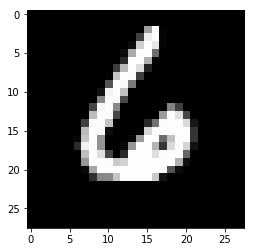

In [7]:
plt.imshow(X_train[311].reshape(28,28))
plt.show()

In [8]:
# Normalise data between -1 and 1


X_train = (X_train.astype('float32') - 127.5)/127.5
print(X_train.min())
print(X_train.max())
print(X_train.shape)

-1.0
1.0
(60000, 28, 28, 1)


In [0]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = X_train.shape[0]//BATCH_SIZE
HALF_BATCH = 128
NOISE_DIM = 100     #Upsample this vector in 784 
adam = Adam(lr=2e-4,beta_1=0.5)

In [11]:
# Generator Model - Learnable Upsampling

generator = Sequential()
generator.add(Dense(7*7*128, input_shape=(NOISE_DIM,))) # Upsampling 100 noise vector to 6272 dimn vector
generator.add(Reshape((7,7,128))) # reshape to 3D 
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())


# From (7,7,128) to (14,14,64) 


# If you follow upsample + conv 
# generator.add(UpSampling2D())
# generator.add(Conv2D(filters=64, kernel_size=(5,5), padding='same'))

# This is learnable upsampling
generator.add(Conv2DTranspose(64, kernel_size=(5,5), padding='same', strides=(2,2)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())


# From (14,14,64) to (28,28,1)


# generator.add(UpSampling2D())
# generator.add(Conv2D(filters=1, kernel_size=(5,5), padding='same', activation='tanh'))
generator.add(Conv2DTranspose(1, kernel_size=(5,5), padding='same', strides=(2,2), activation="tanh"))


generator.compile(loss="binary_crossentropy", optimizer=adam)
generator.summary()

W0801 10:30:16.586112 139686258624384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0801 10:30:16.600769 139686258624384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
__________

In [12]:
#  Discriminator Model

# Recieve an input image of (28,28,1) and convert to (14,14,64)
discriminator = Sequential()
discriminator.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding="same", input_shape=(28,28,1) ))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())

# Convert (14,14,64) to (7,7,128)
discriminator.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding="same" ))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())

# Convert (7,7,128) to Flatten vector of dimn 6272
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.compile(loss="binary_crossentropy", optimizer= adam)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [0]:
#  Create GAN 

discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generate_img = generator(gan_input)
gan_output = discriminator(generate_img)


# Keras Functional API for combining both models

model = Model(inputs= gan_input, outputs = gan_output)
model.compile(loss="binary_crossentropy", optimizer=adam)

In [0]:
def save_images(epoch, samples=100):
  noise = np.random.normal(0, 1, size=(samples, NOISE_DIM))
  generated_img = generator.predict(noise)
  generated_img = generated_img.reshape(-1,28,28)
  
  plt.figure(figsize=(10,10))
  for i in range(samples):
    plt.subplot(10,10,i+1)
    plt.imshow(generated_img[i], interpolation='nearest')
    plt.axis("off")
  
  plt.tight_layout()
  plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
  plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 Disc Loss 0.4034 Generator Loss 3.0827
Epoch 2 Disc Loss 0.4068 Generator Loss 2.7412
Epoch 3 Disc Loss 0.3929 Generator Loss 2.8666
Epoch 4 Disc Loss 0.4009 Generator Loss 2.7839
Epoch 5 Disc Loss 0.3942 Generator Loss 2.7373
Epoch 6 Disc Loss 0.4103 Generator Loss 2.6964
Epoch 7 Disc Loss 0.3746 Generator Loss 2.7475
Epoch 8 Disc Loss 0.3778 Generator Loss 2.7711
Epoch 9 Disc Loss 0.3388 Generator Loss 2.8798
Epoch 10 Disc Loss 0.3687 Generator Loss 2.8610


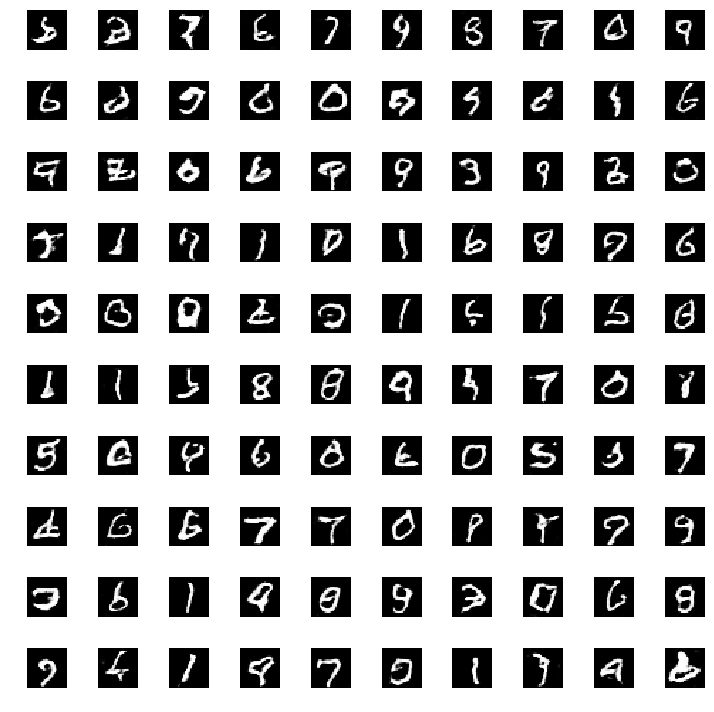

Epoch 11 Disc Loss 0.3330 Generator Loss 3.0387
Epoch 12 Disc Loss 0.3672 Generator Loss 2.9956
Epoch 13 Disc Loss 0.3093 Generator Loss 3.1160
Epoch 14 Disc Loss 0.3410 Generator Loss 3.0980
Epoch 15 Disc Loss 0.3257 Generator Loss 3.1919
Epoch 16 Disc Loss 0.3101 Generator Loss 3.2388
Epoch 17 Disc Loss 0.3084 Generator Loss 3.3320
Epoch 18 Disc Loss 0.2968 Generator Loss 3.3335
Epoch 19 Disc Loss 0.3099 Generator Loss 3.3869
Epoch 20 Disc Loss 0.2824 Generator Loss 3.4928


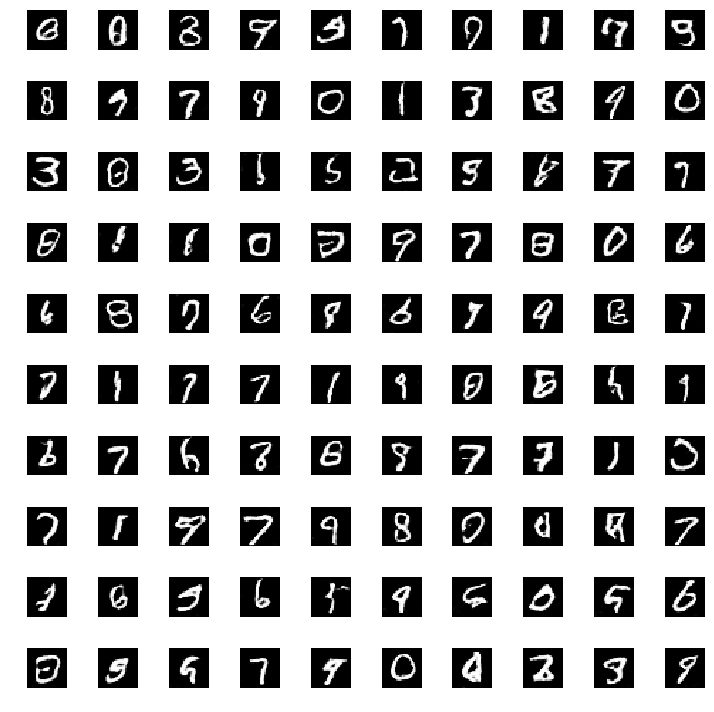

Epoch 21 Disc Loss 0.3009 Generator Loss 3.4332
Epoch 22 Disc Loss 0.2941 Generator Loss 3.5007
Epoch 23 Disc Loss 0.2855 Generator Loss 3.5473
Epoch 24 Disc Loss 0.2933 Generator Loss 3.5568
Epoch 25 Disc Loss 0.2819 Generator Loss 3.5876
Epoch 26 Disc Loss 0.2774 Generator Loss 3.6376
Epoch 27 Disc Loss 0.2772 Generator Loss 3.6719
Epoch 28 Disc Loss 0.2738 Generator Loss 3.7269
Epoch 29 Disc Loss 0.2884 Generator Loss 3.7435
Epoch 30 Disc Loss 0.3022 Generator Loss 3.4858


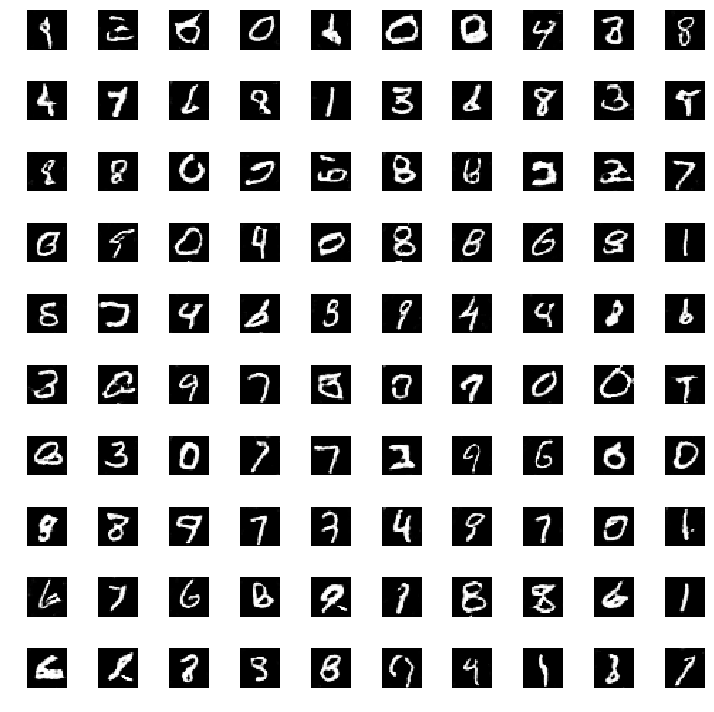

Epoch 31 Disc Loss 0.2588 Generator Loss 3.7540
Epoch 32 Disc Loss 0.2652 Generator Loss 3.7611
Epoch 33 Disc Loss 0.2673 Generator Loss 3.7840
Epoch 34 Disc Loss 0.2779 Generator Loss 3.7715
Epoch 35 Disc Loss 0.2696 Generator Loss 3.7438
Epoch 36 Disc Loss 0.2533 Generator Loss 3.8516
Epoch 37 Disc Loss 0.3060 Generator Loss 3.7046
Epoch 38 Disc Loss 0.2922 Generator Loss 3.7686
Epoch 39 Disc Loss 0.2455 Generator Loss 3.8082
Epoch 40 Disc Loss 0.2807 Generator Loss 3.7582


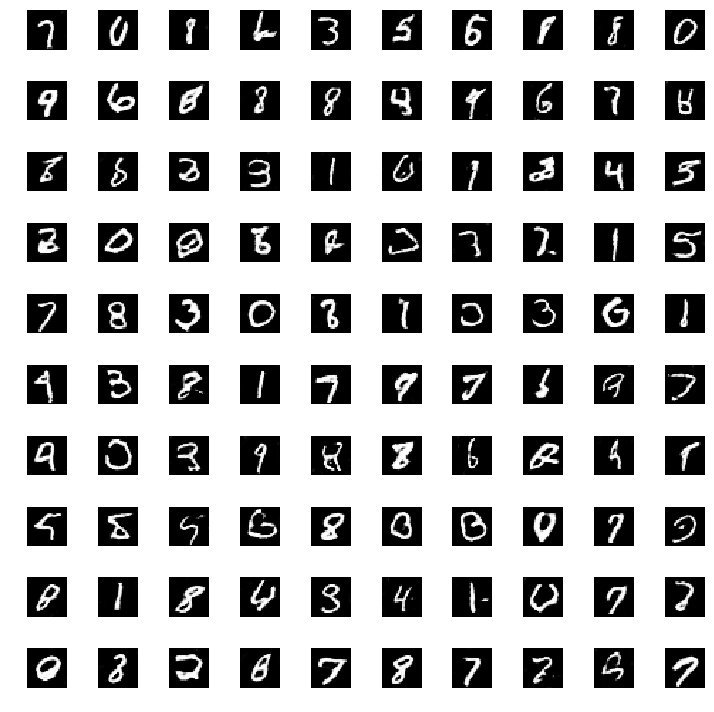

Epoch 41 Disc Loss 0.2453 Generator Loss 3.8324
Epoch 42 Disc Loss 0.3276 Generator Loss 3.5752
Epoch 43 Disc Loss 0.2507 Generator Loss 3.7598
Epoch 44 Disc Loss 0.2960 Generator Loss 3.6877
Epoch 45 Disc Loss 0.2570 Generator Loss 3.8199
Epoch 46 Disc Loss 0.2369 Generator Loss 3.9038
Epoch 47 Disc Loss 0.3170 Generator Loss 3.7217
Epoch 48 Disc Loss 0.2405 Generator Loss 3.8170
Epoch 49 Disc Loss 0.2837 Generator Loss 3.8168
Epoch 50 Disc Loss 0.2490 Generator Loss 3.9143


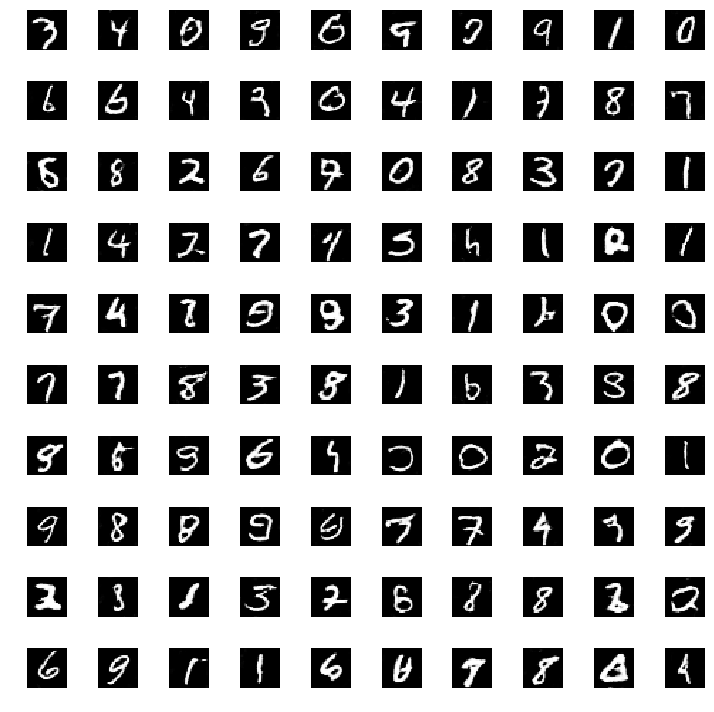

In [18]:
# Training GAN 

discriminator_losses = []
generator_losses = []

for epoch in range(TOTAL_EPOCHS):
  epoch_d_loss = 0.
  epoch_g_loss = 0.
  
  # Mini Batch SGD
  for batch in range(NO_OF_BATCHES):
    
    # Step 1 Train Discriminator
    # 50% Real Data + 50% Fake Data
    
    # Real Data X
    idx = np.random.randint(0,X_train.shape[0],HALF_BATCH)
    real_imgs = X_train[idx]
    
    # Fake Data X
    noise = np.random.normal(0,1, size=(HALF_BATCH,NOISE_DIM))
    fake_imgs = generator.predict(noise) # Forward Pass
    
    # Labels
    real_y = np.ones((HALF_BATCH,1))*0.9 #One side Label Smoothing for Discriminator
    fake_y = np.zeros((HALF_BATCH,1))
    
    
    # Train Discriminator
    
    d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
    
    epoch_d_loss += d_loss
    
    
    
    
    
    # Step 2 Train Generator
    noise = np.random.normal(0, 1, size=(BATCH_SIZE,NOISE_DIM))
    ground_truth_y = np.ones((BATCH_SIZE,1))
    g_loss = model.train_on_batch(noise, ground_truth_y)
    
    epoch_g_loss += g_loss
    
    
    
  print("Epoch %d Disc Loss %.4f Generator Loss %.4f" %((epoch+1),epoch_d_loss/NO_OF_BATCHES,epoch_g_loss/NO_OF_BATCHES))
  discriminator_losses.append(epoch_d_loss)
  generator_losses.append(epoch_g_loss)
  
  if(epoch+1)%10==0:
    generator.save("model/generator_{0}.h5".format(epoch+1))
    save_images(epoch)

In [17]:
# !mkdir images
# !mkdir model
# !ls

images	images.zip  model  model.zip  sample_data


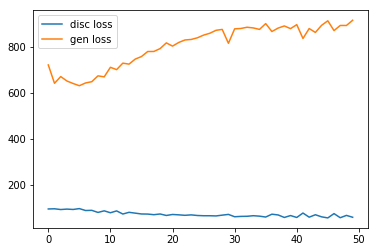

In [19]:
plt.plot(discriminator_losses, label= "disc loss")
plt.plot(generator_losses, label="gen loss")
plt.legend()
plt.show()

In [20]:
!zip -r /content/images.zip  /content/images

updating: content/images/ (stored 0%)
updating: content/images/gan_output_epoch_50.png (deflated 9%)
updating: content/images/gan_output_epoch_10.png (deflated 9%)
updating: content/images/gan_output_epoch_40.png (deflated 9%)
updating: content/images/gan_output_epoch_20.png (deflated 9%)
updating: content/images/gan_output_epoch_30.png (deflated 9%)


In [0]:
from google.colab import files
files.download("images.zip")